## Projekt zaliczeniowy

### Pobieranie danych


Funkcje służące do pobierania danych umieściłem w pakiecie *buses* w module *harvesting*. 

In [1]:
# Korzystam z poniższych bibliotek
import time
import requests
import json
import os

In [2]:
def harvestData(duration: float, fileName: str, directory: str):
    """
    Pobieraj dane przez 'duration' godzin do ścieżki 'directory' do plików o nazwach 'fileName'.
    """
    endpoint = 'https://api.um.warszawa.pl/api/action/busestrams_get/'
    callParameters = {
        'resource_id': 'f2e5503e-927d-4ad3-9500-4ab9e55deb59',
        'apikey': 'db787e64-34d2-4757-a506-a9e63d44a8a8',
        'type': '1'
    } 
    collectedData = {}
    
    stopTime = time.time() + (duration * 3600)
    recordID = 0
    while(stopTime - time.time() > 0):
        response = requests.get(endpoint, params = callParameters)
        if response.status_code == 200:
            response = response.json()["result"]
            collectedData[recordID] = response
            recordID += 1
            time.sleep(10)
    
    fullDirectory = os.path.join(directory, fileName + '.json')
    with open(fullDirectory, "w") as file:
        json.dump(collectedData, file)

def harvestFullDayData(folderName: str):
    """
    Pobieraj dane przez jedną dobę do folderu o nazwie 'folderName'.
    """
    directory = os.path.join(os.getcwd(), folderName)
    if not os.path.isdir(directory):
        os.mkdir(directory)
    
    for hour in range(1, 25):
        harvestData(1, f'hour{hour}', directory)

Funkcja *harvestData* pozwala pobierać dane przez dowolną ilość czasu, lecz dla własnej wygody napisałem też funkcję *harvestFullDayData*, która pobiera dane przez pełną dobę.  
Dane są zapisywane w plikach .json o nazwach "hour{numer_godziny}" w folderze o nazwie wybranej przez użytkownika.  
Pliki *hour* są słownikami, w których kluczami są numery odpowiedzi (zaczynając od zera), a wartościami odpowiedzi zwrócone przez serwer.

### Analiza danych

Wszystkie funkcje, które wykorzystuję do analizowania pozyskanych przy pomocy modułu *harvesting* danych umieściłem w tym samym pakiecie *buses* w module *analysis*.

In [3]:
# Korzystam z poniższych bibliotek
import os
import json
import pandas
import numpy
import matplotlib.pyplot
import plotly.graph_objects

#### Usunięcie pustych rekordów

Na część moich zapytań do serwera otrzymałem odpowiedź: "Błędna metoda lub parametry wywołania", więc takich rekordów w danych musiałem się pozbyć przed przystąpieniem do analizy.  
Wykorzystałem do tego funkcję *cleanData*, która tworzy kopię danych bez błędnych rekordów w subfolderze o nazwie "clean{nazwa_folderu_z_danymi}", gdzie drugi człon nazwy rozpoczyna się wielką literą.

In [ ]:
def cleanData(directory: str):
    """
    Stwórz kopię danych spod ścieżki 'directory' bez błędnych rekordów..
    """
    folderName = os.path.basename(directory).capitalize()
    cleanDirectory = os.path.join(directory, f'clean{folderName}')
    if not os.path.isdir(cleanDirectory):
        os.mkdir(cleanDirectory)

    hour = 1
    while(True):
        try:
            fileDirectory = os.path.join(directory, f'hour{hour}.json')
            with open(fileDirectory, 'r') as file:
                hourData = json.load(file)
        except:
            break
        
        index = 0
        cleanHourData = {}
        for record in hourData:
            if hourData[record] != 'Błędna metoda lub parametry wywołania':
                cleanHourData[str(index)] = hourData[record]
                index += 1
        
        cleanFileDirectory = os.path.join(cleanDirectory, f'hour{hour}.json')
        with open(cleanFileDirectory, "w") as cleanFile:
            json.dump(cleanHourData, cleanFile)

        hour += 1

#### Wczytanie danych z plików

Po zapisaniu odpowiedzi serwera do plików, należy je odczytać i uporządkować.  
Najpierw wczytałem wszystkie dane do jednego słownika, którego klucze mają postać "h{numer_godziny}", a wartości to listy (zapytań indeksowane od zera) list (autobusów w zapytaniu).  
np. {'h1': [ [{autobus1}, {autobus2}], [{autobus1, autobus2}] ] }  
Wykorzystałem do tego funkcję *dataToDict*.

In [4]:
def dataToDict(directory: str):
    """
    Odczytaj dane ze ścieżki 'directory' i zwróć je w formie słownika.
    """
    dataDict = {}

    hour = 1
    while(True):
        fileDirectory = os.path.join(directory, f'hour{hour}.json')
        try:
            with open(fileDirectory, 'r') as file:
                hourData = dict(json.load(file))
        except:
            break

        dataDict[f'h{hour}'] = []
        for record in hourData:
            dataDict[f'h{hour}'].append(hourData[record])
        
        hour += 1
    
    return dataDict

directory = os.getcwd() + '\data\cleanData'
fullData = dataToDict(directory)

Następnie umieściłem dane ze słownika w strukturze *DataFrame* z biblioteki *pandas*.
Użyłem funkcji *dictToDataFrame*.

In [5]:
def dictToDataFrame(data: dict):
    """
    Przekształć słownik danych w DataFrame.
    """
    lines = []
    longitudes = []
    vehicleNumbers = []
    times = []
    latitudes = []
    
    for hour in data:
        for record in data[hour]:
            for bus in record:
                lines.append(bus['Lines'])
                longitudes.append(float(bus['Lon']))
                vehicleNumbers.append(bus['VehicleNumber'])
                times.append(bus['Time'])
                latitudes.append(float(bus['Lat']))
    
    dataDict = {'id': vehicleNumbers,
                'line': lines,
                'lon': longitudes,
                'lat': latitudes,
                'time': times}

    dataFrame = pandas.DataFrame(dataDict)
    return dataFrame 

fullData = dictToDataFrame(fullData)

#### Faktyczna analiza danych

Zająłem się głównie analizą prędkości autobusów, więc musiałem dodać kolumnę prędkość do *DataFrame*-u.  
Przydała mi się bibliotek numpy oraz wzór na odległość, na powierzchni kuli.  
Wykorzystałem funkcję *addSpeed* i pomocniczą *distance*.

In [6]:
def distance(latitude1: list, longitude1: list, latitude2: list, longitude2: list):
    """
    Zwróć dystans w metrach między dwoma punktami (operacja na kolumnach tabeli).
    """
    lat1, lon1 = numpy.radians(latitude1), numpy.radians(longitude1)
    lat2, lon2 = numpy.radians(latitude2), numpy.radians(longitude2)
    earthRadius = 6371000
    # Korzysta ze wzoru na odległość haversine
    latDiff = lat2 - lat1
    lonDiff = lon2 - lon1
    distance = 2.0 * earthRadius                                  \
        * numpy.arcsin(numpy.sqrt(numpy.sin(latDiff/2)**2         \
                            + numpy.cos(lat1) * numpy.cos(lat2)   \
                                * numpy.sin(lonDiff/2)**2))
    return distance

def addSpeed(data: pandas.DataFrame):
    """
    Dodaj do DataFrame z danymi kolumnę prędkość.
    """
    data['time'] = pandas.to_datetime(data['time'], errors='coerce')
    data.sort_values(by=['id', 'time'], inplace=True)
    data['timeDiff'] = data.groupby('id')['time'].diff().dt.total_seconds()
    data['distance'] = distance(data['lat'].shift(), data['lon'].shift(), data['lat'], data['lon'])
    data['speed'] = (data['distance'] / data['timeDiff']) * 3.6
    return data

fullData = addSpeed(fullData)

W tym miejscu okazało się, że istnieją rekordy dla których prędkość jest wielokrotnie wyższa niż przewiduje zdrowy rozsądek i prawa fizyki, dlatego zdecydowałem się odrzucić wszystkie wyniki powyżej 100 km/h. Wybrałem akurat 100 km/h, ponieważ tyle wynosi ograniczenie prędkości dla autobusów na autostradach.  
Wykorzystałem funkcję *discardOver100kmph*.

In [7]:
def discardOver100kmph(data: pandas.DataFrame):
    """
    Odrzuć rekordy z prędkością powyżej 100 km/h.
    """
    afterDiscard = data[data['speed'] <= 100]
    return afterDiscard

fullData = discardOver100kmph(fullData)

Uznałem, że ciekawym będzie przeprowadzenie oddzielnych analiz dla 3 przedziałów czasowych:  
- godzin szczytu
- godzin ze środka dnia
- nocy  

Dlatego umieściłem przefiltrowane ze względu na czas rekordy w 3 dodatkowych *DataFrame*-ach.

In [15]:
fullData.reset_index(inplace = True)
fullData.set_index('time', inplace = True)

peakMorningData = fullData.between_time('5:00', '9:00')
peakEveningData = fullData.between_time('15:00', '19:00')
peakData = pandas.concat([peakMorningData, peakEveningData])
peakData.reset_index(inplace = True)

nightData = fullData.between_time('0:00', '5:00')
nightData.reset_index(inplace = True)

middleData = fullData.between_time('9:00:00', '15:00')
middleData.reset_index(inplace = True)

fullData.reset_index(inplace = True)

Najpierw zdecydowałem się odpowiedzieć na pytanie: Ile autobusów przekroczyło prędkość 50 km/h?  
Użyłem do tego funkcji *speedingBusesCount*.


In [ ]:
def speedingBusesCount(data: pandas.DataFrame):
    """
    Policz autobusy, które przekroczyły 50 km/h.
    """
    over50 = data[data['speed'] > 50]
    busesCount = over50['id'].nunique()
    return busesCount

peakCount = speedingBusesCount(peakData)
middleCount = speedingBusesCount(middleData)
nightCount = speedingBusesCount(nightData)
print(f'peak: {peakCount}, middle: {middleCount}, night: {nightCount}')

Następnie sprawdziłem, które linie miały najwięcej autobusów, które przekroczyły prędkość.  
Wykorzystałem funkcję *mostSpeedingLines*, która pozwala wypisać dowolną ilość takich linii (ja wybrałem 3).

In [ ]:
def mostSpeedingLines(data: pandas.DataFrame, top: int):
    """
    Wskaż 'top' linii autobusowych, których największa liczna autobusów przekroczyła 50km/h.
    """
    data = discardOver100kmph(data)
    data = data[data['speed'] > 50]
    data = data.groupby('line')['id'].nunique()
    data = data.sort_values(ascending=False).head(top)
    return data

peakLines = mostSpeedingLines(peakData, 3)
middleLines = mostSpeedingLines(middleData, 3)
nightLines = mostSpeedingLines(nightData, 3)
print('peak:')
print(peakLines)
print('middle:')
print(middleLines)
print('night:')
print(nightLines)


Potem chciałem obliczyć średnią prędkość autobusów, ale pojawił się pewien problem. Okazało się, że znaczącą część danych stanowią rekordy z prędkością niższą niż 5 km/h, co wydaje się nieprawdopodobne i zaburza średnią.  
Poniższy wykres przygotowałem na podstawie danych z całego dnia, przy pomocy funkcji *speedDistributionGraph*, która korzysta z biblioteki *matplotlib*.

In [ ]:
def speedDistributionGraph(data: pandas.DataFrame):
    """
    Narysuj wykres rozkładu prędkości.
    """
    totalRecords = len(data.index)
    speedRanges = ['v <= 5'] + [f'{x} < v <= {x + 5}' for x in range(5, 95, 5)] + ['95 < v']
    parts = []
    
    selectedData = data[data['speed'] <= 5]
    selectedRecords = len(selectedData.index)
    ratio = selectedRecords / totalRecords
    parts.append(round(ratio, 4))
    for lowerBound in range(5, 100, 5):
        upperBound = lowerBound + 5
        selectedData = data[data['speed'] > lowerBound]
        selectedData = selectedData[selectedData['speed'] <= upperBound]
        selectedRecords = len(selectedData.index)
        ratio = selectedRecords / totalRecords
        parts.append(round(ratio, 4))
    
    labels = [f'{speedRanges[i]} ({parts[i]})' for i in range(len(speedRanges))]
    fig, ax = matplotlib.pyplot.subplots()
    ax.pie(parts)
    matplotlib.pyplot.legend(labels, title='Przedziały prędkości', loc='best', fontsize = 14)
    matplotlib.pyplot.axis('equal')
    matplotlib.pyplot.title('Rozkład prędkości autobusów [km/h]', fontsize = 16)
    return fig

errorGraph = speedDistributionGraph(fullData)
matplotlib.pyplot.show()

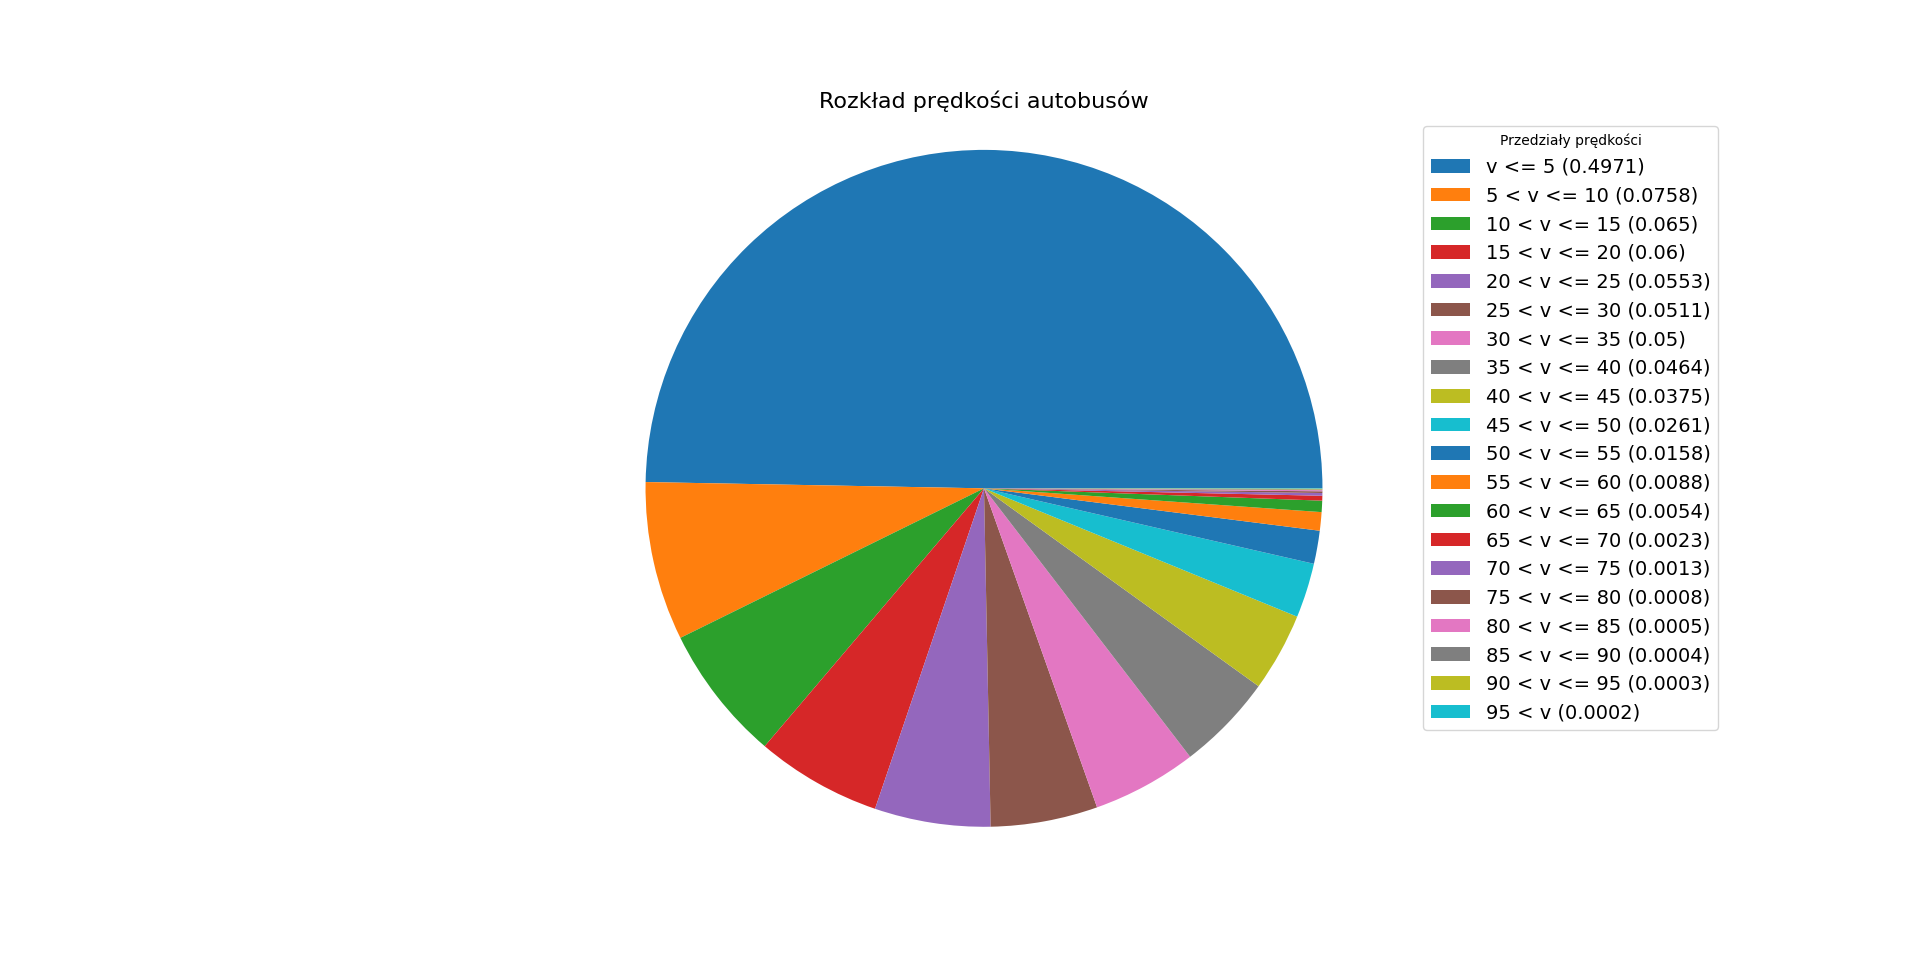

Wydaje mi się, że może to wynikać z tego, że autobusy wysyłają swoją lokalizację nawet jeśli stoją na pętli. Niezależnie od przyczyny wydaje mi się być uczciwym wyfiltrowanie prędkości poniżej 5 km/h w celu obliczenia średniej i uzyskania bardziej wiarygodnego rozkładu prędkości.  
Do obliczenia średniej użyję funkcji *averageSpeed*.

In [ ]:
def averageSpeed(data: pandas.DataFrame):
    """
    Oblicz średnią prędkość autobusów.
    """
    return (sum(data['distance']) / sum(data['timeDiff'])) * 3.6

peakDataOver5 = peakData[peakData['speed'] > 5]
middleDataOver5 = middleData[middleData['speed'] > 5]
nightDataOver5 = nightData[nightData['speed'] > 5]

peakAverage = averageSpeed(peakDataOver5)
middleAverage = averageSpeed(middleDataOver5)
nightAverage = averageSpeed(nightDataOver5)
print(f'peak: {peakAverage}, middle: {middleAverage}, night: {nightAverage}')

A do wygenerowania wykresów, wspomnianej wyżej *speedDistributionGraph*.

In [ ]:
peakGraph = speedDistributionGraph(peakDataOver5)
matplotlib.pyplot.show()
middleGraph = speedDistributionGraph(peakDataOver5)
matplotlib.pyplot.show()
nightGraph = speedDistributionGraph(peakDataOver5)
matplotlib.pyplot.show()

Na koniec wygenerowałem mapy Warszawy z zaznaczonymi punktami przekroczenia prędkości.  
Wykorzystałem funkcję *over50Map*, opartą na bibliotece *plotly*.

In [ ]:
def over50Map(data: pandas.DataFrame):
    """
    Zaznacz na mapie Warszawy punkty, gdzie zostało przekroczone 50 km/h.
    """
    over50 = data[data['speed'] > 50]

    fig = plotly.graph_objects.Figure(plotly.graph_objects.Densitymapbox(
    lat = over50['lat'],
    lon = over50['lon'],
    z = over50['speed'],
    radius = 10, 
    colorscale = 'geyser',
    colorbar = dict(title='Speed [km/h]')
    ))
    
    fig.update_layout(
        mapbox_style = 'carto-positron',
        mapbox_center = {'lat': 52.2297, 'lon': 21.0122},  # Centered around Warsaw
        mapbox_zoom = 10
    )

    return fig

peakMap = over50Map(peakData)
middleMap = over50Map(middleData)
nightMap = over50Map(nightData)
#peakMap.show()
#middleMap.show()
#nightMap.show()

fullMap = over50Map(fullData)
#fullMap.show()

Po obejrzeniu mapy opartej na danych z całej doby doszedłem do wniosku, że autobusy najczęściej przekraczają dozwoloną prędkość w poniższych miejscach:  
- Most Łazienkowski
- Most Generała Stefana Grota
- Most Siekierkowski
- Aleja Armii Ludowej na wysokości skrzyżowania Rozbratu i Myśliwieckiej
- Aleja Józefa Becka
- Aleje Jerozolimskie 
- Aleja Prymasa Tysiąclecia
- ulica Płowiecka
- ulica Bronisława Czecha
- ulica Stołeczna na wysokości Zaborówek
- ulica Modlińska